## Imports

In [3]:
import cv2
import numpy as np
import mediapipe as mp
from numpy import save
import math as m
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from numpy import moveaxis
from numpy import asarray
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.linalg import multi_dot
import config
from utils import *
from matplotlib import cm
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from image2image import RenderImage
from test import UseWebcam
from generator_model import GeneratorUNet
from discriminator_model import Discriminator
from dataset import ImageDataset


## Read data

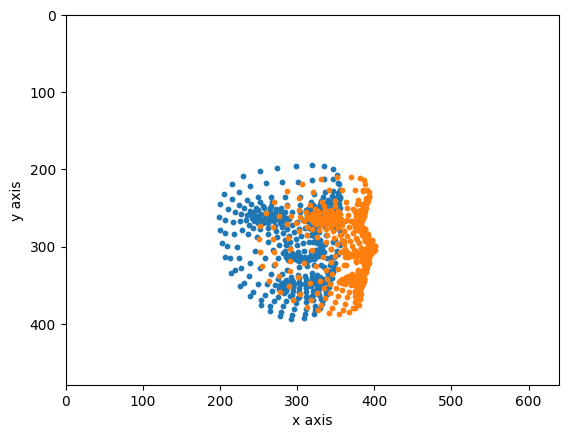

In [5]:
imgRef = torchvision.io.read_image(config.PathImg1)
imgTar = torchvision.io.read_image(config.PathImg2)

refKey = torch.tensor(np.load(config.PathNPY1), device=config.DEVICE)
tarKey = torch.tensor(np.load(config.PathNPY2), device=config.DEVICE)

height, width = imgRef.shape[1], imgRef.shape[2]
draw(width, height, refKey, tarKey, size=10, connect=False)

## Data Loader

In [4]:
class ImageDataSet(Dataset):
    def __init__(self, images, keys):
        self.Images = images
        self.Keys = keys

    def __len(self):
        return len(self.Keys)

    def __getitem__(self, idx):
        return self.Images[idx], self.Keys[idx]

In [4]:
img_names = os.listdir(path)
NumberImages = 396
images = torch.zeros(NumberImages, NUM_CHANNALS, height, width)
keys = torch.zeros(NumberImages, FACE_LANKMARK_LENGTH, NUMBER_COORDINATE)
idx = 0
for i in range(NumberImages):
    img_name = path + "\Image_" + str(i) + ".jpg"
    key_name = path + "\Image_" + str(i) + ".npy"
    image = torchvision.io.read_image(img_name)
    key = torch.tensor(np.load(key_name), device=DEVICE)
    images[i] = image
    keys[i] = key
    

In [5]:
MyDataSet = ImageDataSet(images, keys)

## Transform data

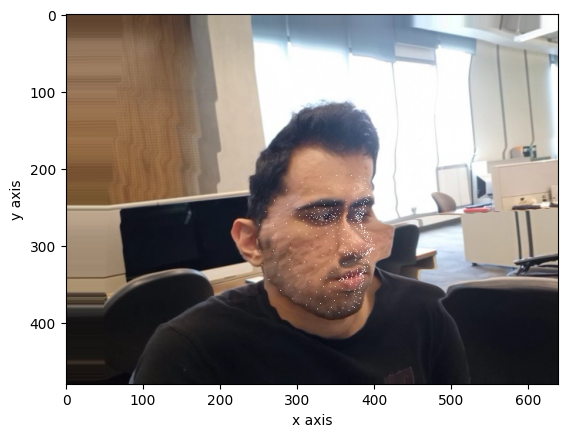

In [9]:
output = RenderImage(height, width, refKey, tarKey, imgRef, sd=0.01)

dummy = torch.squeeze(output)
dummy = createMask(tarKey, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
# showImageTensor(output.int(), is3chan=True, isOutput=True)
# showImageTensor(output, isOutput=True)

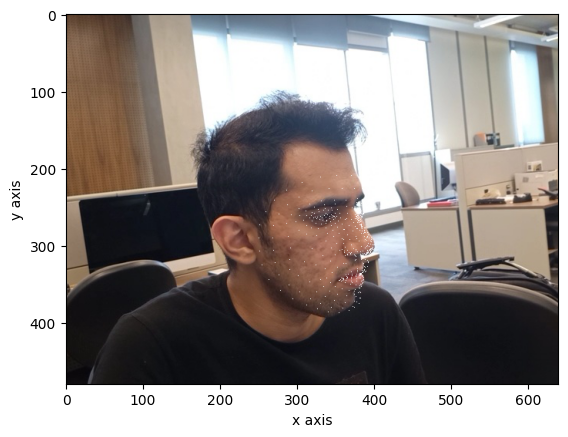

In [11]:
mm = createMask(tarKey, height, width, imgTar)

showImageTensor(mm, is3chan=True)

## Slide Video

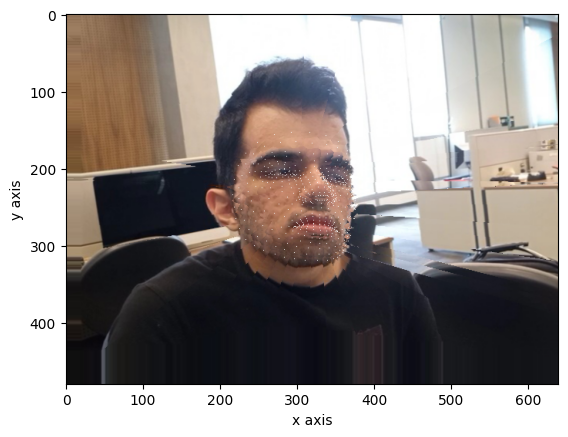

In [6]:
frameSize = (640, 480)

out = cv2.VideoWriter('rotation-X2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 0
j = 0
k = 0
T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
# T = torch.tensor([0, 0, 0], device=DEVICE)

for i in range(-45, 45):
  euler = torch.tensor([i * pi/180, j * pi/180, k * pi/180], device=DEVICE)
  newKeys = TransformKeys(refKey, euler, T)
  output = RenderImage(height, width, refKey, newKeys, imgRef, sd=0.001, distMethod="gaussian")

  dummy = torch.squeeze(output)
  dummy = createMask(newKeys, height, width, dummy).int()
  
  img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
  img = np.moveaxis(np.uint8(img), 0, -1)
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


out.release()

## Single output

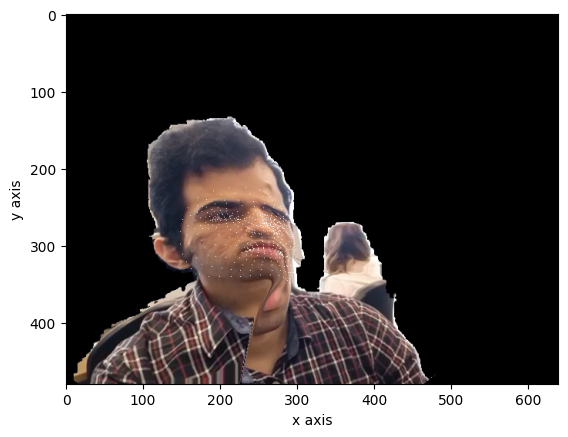

In [13]:
# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE) #+ torch.tensor([-0.3, 0.3, 0], device=DEVICE)
T = torch.tensor([0, 0, 0], device=DEVICE)

euler = torch.tensor([pi/3, 0, 0], device=DEVICE)
newKeys = TransformKeys(refKey, euler, T)
output = RenderImage(height, width, refKey, newKeys, imgRef)

dummy = torch.squeeze(output)
dummy = createMask(newKeys, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)


## Webcam

In [3]:
UseWebcam(height, width, refKey, imgRef)


## Network

In [17]:
MyNet = ViewNet().to(DEVICE)

In [18]:
ref = imgRef.clone().detach().to(DEVICE).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


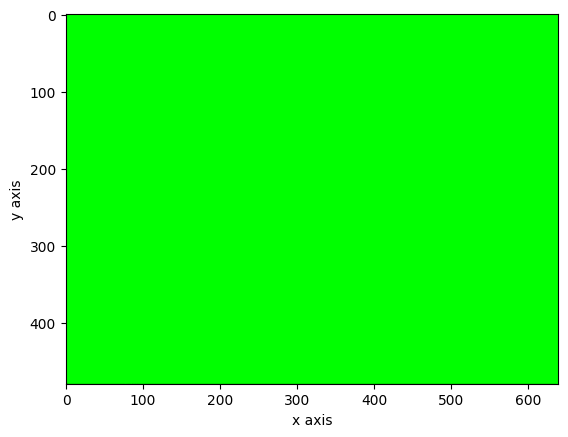

In [19]:
output3 = MyNet(height, width, refKey, tarKey, ref, sd=0.03)
dummy = torch.squeeze(output3 * 255)
# dummy = createMask(tarKey, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
# showImageTensor(output.int(), is3chan=True, isOutput=True)
# showImageTensor(output, isOutput=True)

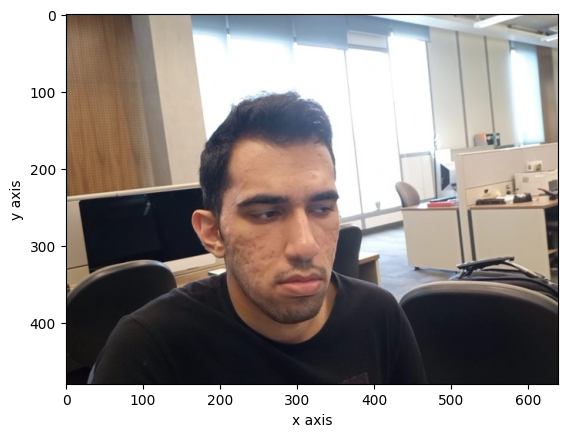

In [20]:
img = showImageTensor(ref/255, is3chan=True, isOutput=True, returnOutput=True)

In [33]:
loss = nn.MSELoss()
optimizer = optim.SGD(MyNet.parameters(), lr=0.00001)

In [ ]:
import torch
import torch.nn as nn


criterion = nn.L1Loss()
for i in range(10000):
    optimizer.zero_grad()
    output3 = MyNet(height, width, refKey, refKey, ref, sd=0.001)
    dummy = torch.squeeze(output3)
    # output = mae_loss(input, target)
    loss = criterion(dummy, ref/255)
    print(loss)
    loss.backward()
    optimizer.step()

## GAN Model

In [6]:
generator = GeneratorUNet()
discriminator = Discriminator()

In [8]:
generator.to(config.DEVICE)
discriminator.to(config.DEVICE)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=config.LEARNING_RATE)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config.LEARNING_RATE)